In [23]:
import proplot as pplt
import matplotlib as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
import cartopy.crs as ccrs
from scipy.optimize import curve_fit
from scipy.stats import norm, expon, lognorm
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import matplotlib.patches as mpatches 

from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import array_bounds

## Class

In [14]:
yearly_images = dict()
for year in [2019, 2020, 2021, 2022, 2023]:
    yearly_images[year] = rio.open(f'./Data/Yearly Images/upscaled_class_{year}.tif', 'r')

counties = gpd.read_file('./Data/counties_2019.geojson')

In [15]:
dest_crs = ccrs.LambertConformal(central_longitude=-76.0, central_latitude=42.0,)

def prepare_for_viz(raster_file, dest_crs):
    transform, width, height = calculate_default_transform(
        raster_file.crs, dest_crs, raster_file.width, raster_file.height, *raster_file.bounds)
    
    new_image, new_transform = reproject(
        source=raster_file.read(),
        src_transform=raster_file.transform,
        src_crs=raster_file.crs,
        dst_crs=dest_crs,
        resampling=Resampling.nearest,
        dst_nodata=np.nan)
    
    new_bounds = array_bounds(new_image.shape[1], new_image.shape[2], new_transform)
    
    return new_image, new_bounds

reproj_images = dict()
bounds = dict()

for year in [2019, 2020, 2021, 2022, 2023]:
    reproj_images[year], bounds[year] = prepare_for_viz(yearly_images[year], dest_crs)

In [16]:
def expand(x):
    if x.geometry.geom_type == 'Polygon':
        return [x.geometry]
    else: 
        return [g for g in x.geometry.geoms]
        
counties["geometries"] = counties.apply(expand, axis=1)
counties = counties.explode(column="geometries").drop(columns="geometry").set_geometry("geometries").rename_geometry("geometry")

C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


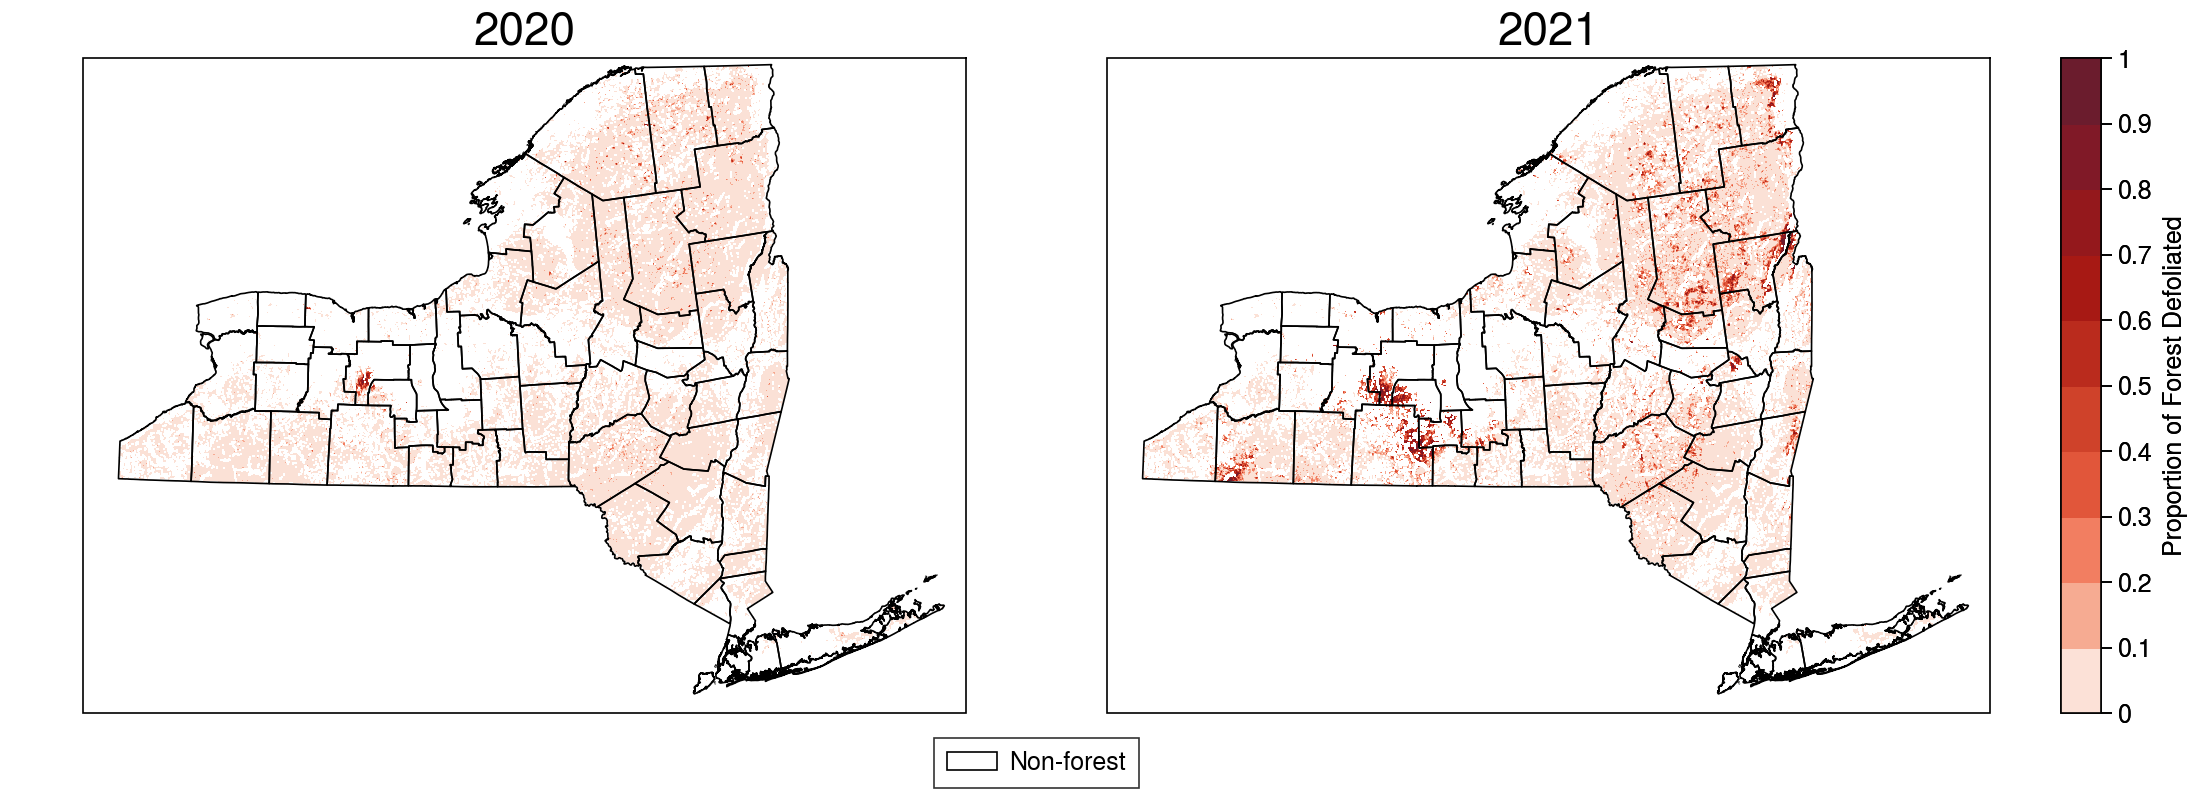

In [27]:
fig, axes = pplt.subplots(nrows=1, ncols=2, figsize=(11,4), proj=dest_crs, facecolor='white', fontsize=15)

#axes.format(abc='A.', abcloc='ul')

vmax = 1
vmin = 0

for i, year in enumerate([2020, 2021]):
    m = axes[i].imshow(reproj_images[year][0], cmap='Reds3', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
                   extent=[bounds[year][0], bounds[year][2], bounds[year][1], bounds[year][3]])
    axes[i].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
    axes[i].format(grid=False, facecolor='white', title=year)

    for row in counties.itertuples():
        region = ShapelyFeature(row.geometry,
                                ccrs.PlateCarree(),
                                facecolor='none',
                                edgecolor='black'
                               )
        axes[i].add_feature(region)
        


fig.colorbar(m, label='Proportion of Forest Defoliated', ticks=0.1, loc='r')

non_forest = mpatches.Patch(facecolor='white', edgecolor='black', label='Non-forest')
fig.legend(loc='b', handles=[non_forest])

fig.savefig('./Figures/Yearly Images/two_year_class_map_upscaled.png')

In [18]:
dest_crs = ccrs.LambertConformal(central_longitude=-76.0, central_latitude=42.0,)

fig, axes = pplt.subplots(nrows=3, ncols=2, figsize=(11,8), proj=dest_crs, facecolor='white', fontsize=15)

#axes.format(abc='A.', abcloc='ul')

vmax = 1
vmin = 0

for i, year in enumerate([2019, 2020, 2021, 2022, 2023]):
    m = axes[i].imshow(reproj_images[year][0], cmap='Reds3', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
                   extent=[bounds[year][0], bounds[year][2], bounds[year][1], bounds[year][3]])
    axes[i].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
    axes[i].format(grid=False, facecolor='white', title=year)

# Overlay County Outlines
for row in counties.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor='none',
                            edgecolor='black'
                           )
    for ax in axes:
        ax.add_feature(region) 

fig.colorbar(m, label='Anomaly of rescaled EVI', ticks=0.1, loc='r')

#fig.savefig('./Figures/New_York_Defoliation_All_Years.png')

C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnin

Error in callback <function flush_figures at 0x000002239232F040> (for post_execute):


KeyboardInterrupt: 

## Intensity

In [7]:
yearly_images = dict()
for year in [2019, 2020, 2021, 2022, 2023]:
    yearly_images[year] = rio.open(f'./Data/Yearly Images/upscaled_intensity_{year}.tif', 'r')

counties = gpd.read_file('./Data/counties_2019.geojson')

In [8]:
dest_crs = ccrs.LambertConformal(central_longitude=-76.0, central_latitude=42.0,)

def prepare_for_viz(raster_file, dest_crs):
    transform, width, height = calculate_default_transform(
        raster_file.crs, dest_crs, raster_file.width, raster_file.height, *raster_file.bounds)
    
    new_image, new_transform = reproject(
        source=raster_file.read(),
        src_transform=raster_file.transform,
        src_crs=raster_file.crs,
        dst_crs=dest_crs,
        resampling=Resampling.nearest,
        dst_nodata=np.nan)
    
    new_bounds = array_bounds(new_image.shape[1], new_image.shape[2], new_transform)
    
    return new_image, new_bounds

reproj_images = dict()
bounds = dict()

for year in [2019, 2020, 2021, 2022, 2023]:
    reproj_images[year], bounds[year] = prepare_for_viz(yearly_images[year], dest_crs)

In [9]:
def expand(x):
    if x.geometry.geom_type == 'Polygon':
        return [x.geometry]
    else: 
        return [g for g in x.geometry.geoms]
        
counties["geometries"] = counties.apply(expand, axis=1)
counties = counties.explode(column="geometries").drop(columns="geometry").set_geometry("geometries").rename_geometry("geometry")

C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


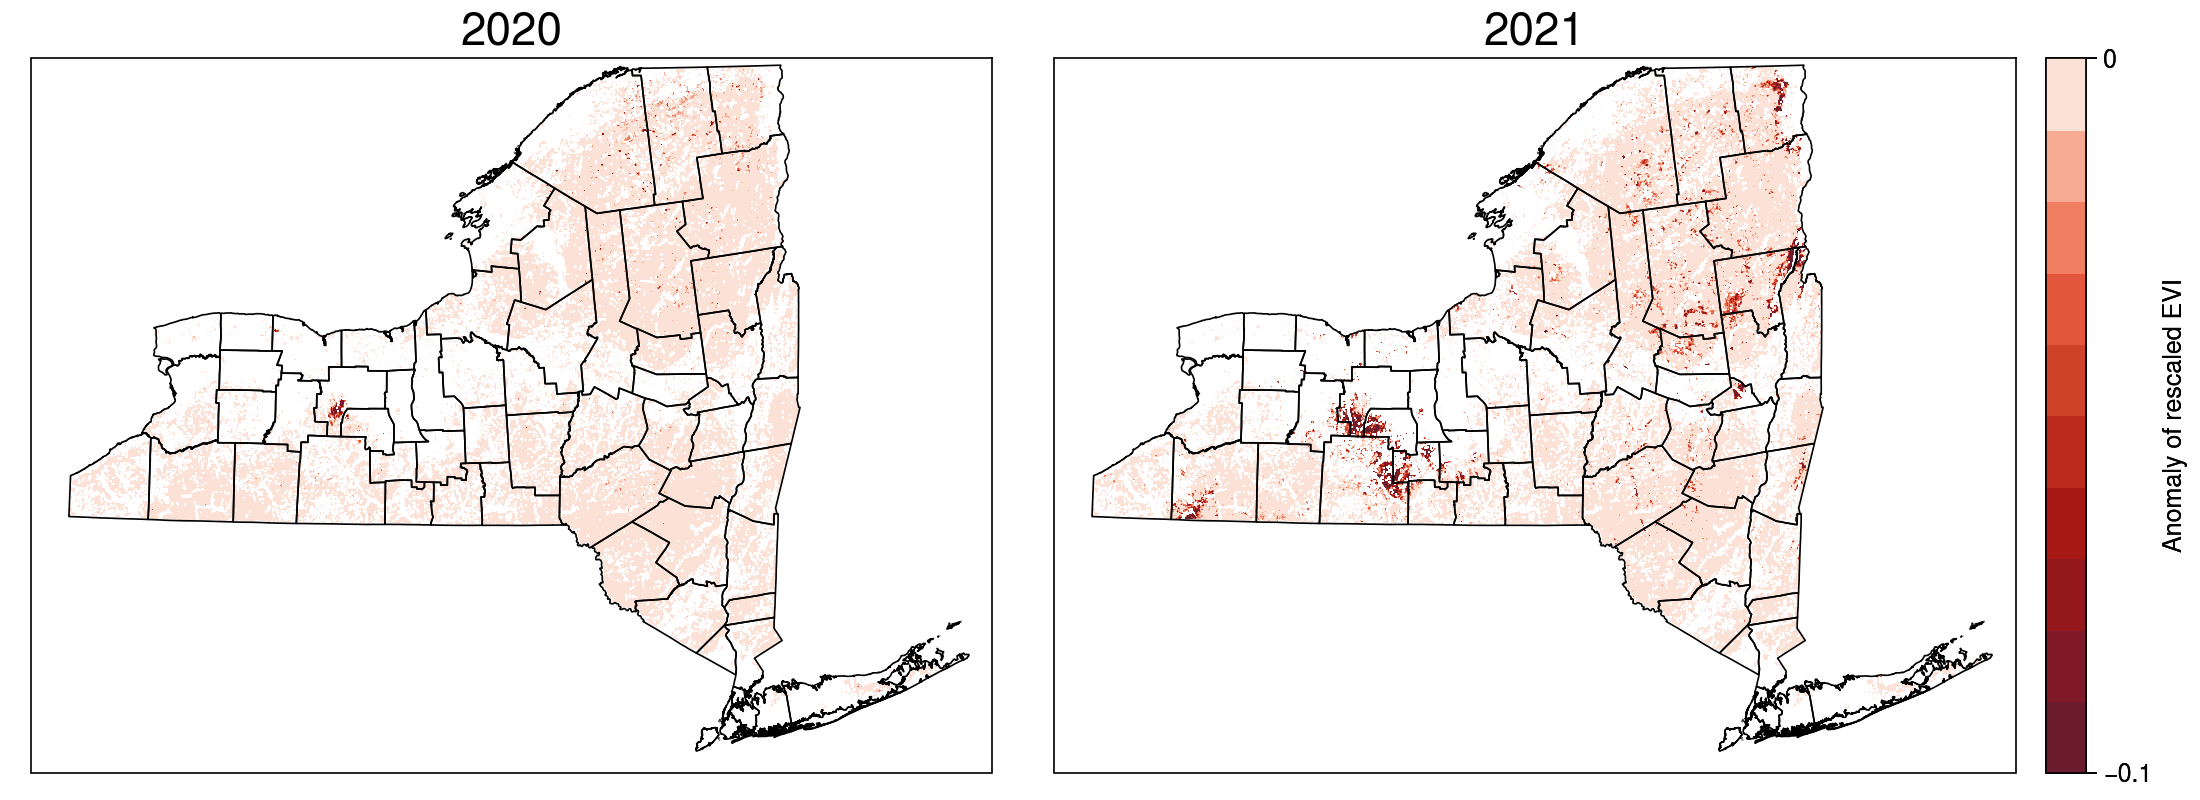

In [10]:
fig, axes = pplt.subplots(nrows=1, ncols=2, figsize=(11,4), proj=dest_crs, facecolor='white', fontsize=15)

#axes.format(abc='A.', abcloc='ul')

vmax = 0
vmin = -0.1

for i, year in enumerate([2020, 2021]):
    m = axes[i].imshow(reproj_images[year][0], cmap='Reds3_r', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
                   extent=[bounds[year][0], bounds[year][2], bounds[year][1], bounds[year][3]])
    axes[i].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
    axes[i].format(grid=False, facecolor='white', title=year)

    for row in counties.itertuples():
        region = ShapelyFeature(row.geometry,
                                ccrs.PlateCarree(),
                                facecolor='none',
                                edgecolor='black'
                               )
        axes[i].add_feature(region)

fig.colorbar(m, label='Anomaly of rescaled EVI', ticks=0.1, loc='r')

fig.savefig('./Figures/Yearly Images/two_year_intensity_map_upscaled.png')

In [11]:
reproj_images[year][0]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [12]:
yearly_images[2019].read()

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])

C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


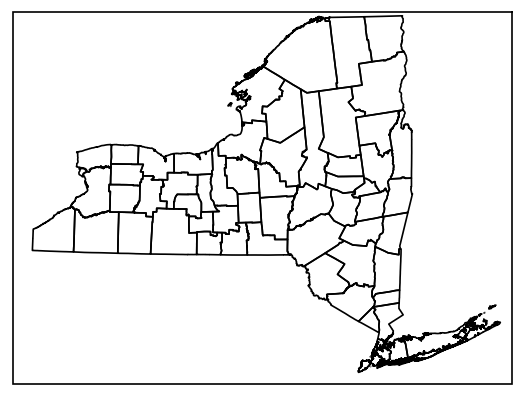

In [32]:
fig, ax = pplt.subplots(nrows=1, ncols=1, proj=dest_crs, facecolor='white', fontsize=15)

for row in counties.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor='none',
                            edgecolor='black'
                           )
    ax.add_feature(region)
ax.set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
ax.format(grid=False, facecolor='white')
fig.savefig('./Figures/Yearly Images/new_york_blank.png')